In [201]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy.constants as const
from scipy.signal import convolve
from scipy.fft import rfft, irfft, rfftfreq
from scipy import signal

# 常量定义
G = const.G # 万有引力常数, m^3 kg^-1 s^-2
c = const.c  # 光速, m/s
msun = 1.989e30  # 太阳质量, kg
pc = 3.086e16  # pc到m的转换

m1：36
m2：29
啁啾质量：28.10
采样率：16384
总样本数：163840
计算的时间延迟: 0.8 秒
透镜效应中的mu_plus: 1.8708
透镜效应中的mu_minus: 1.2247
[-0.8        -0.79993896 -0.79987793 ...  9.19981689  9.19987793
  9.19993896]


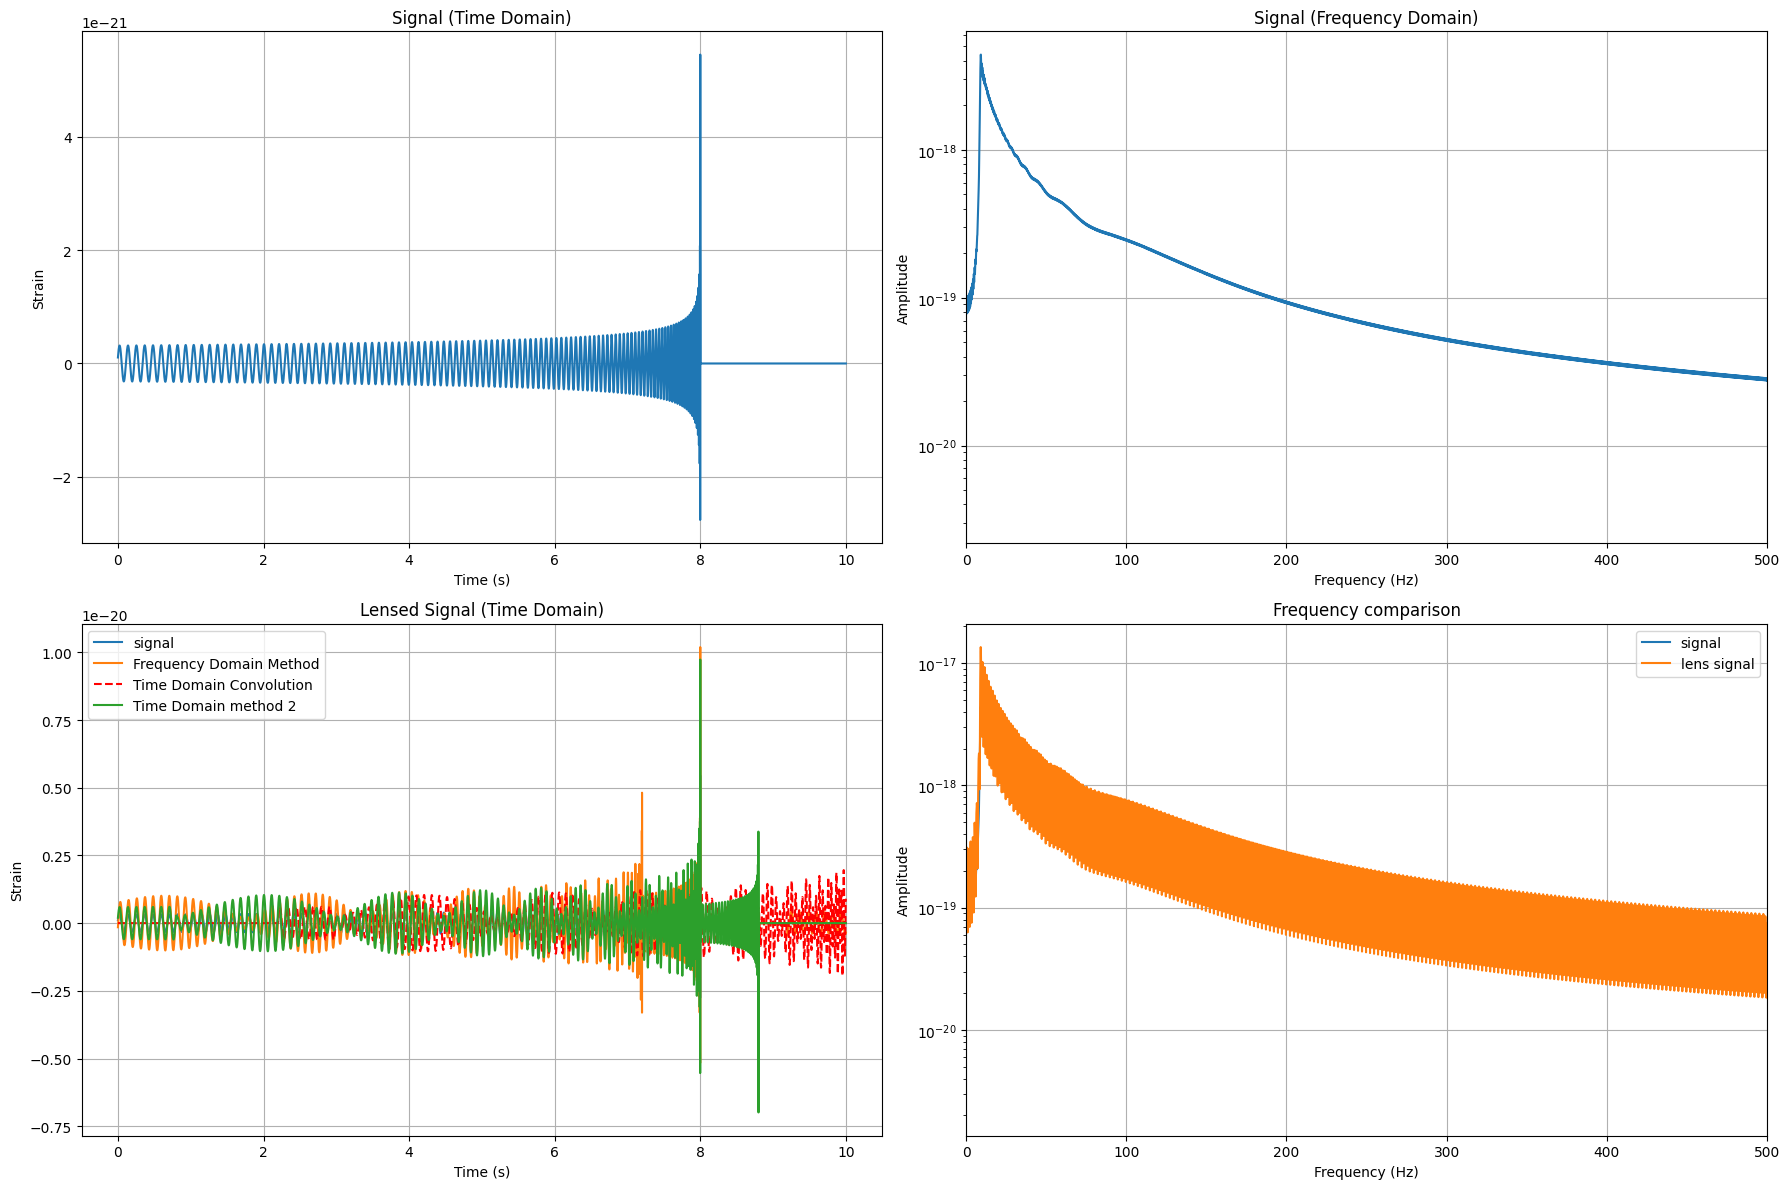

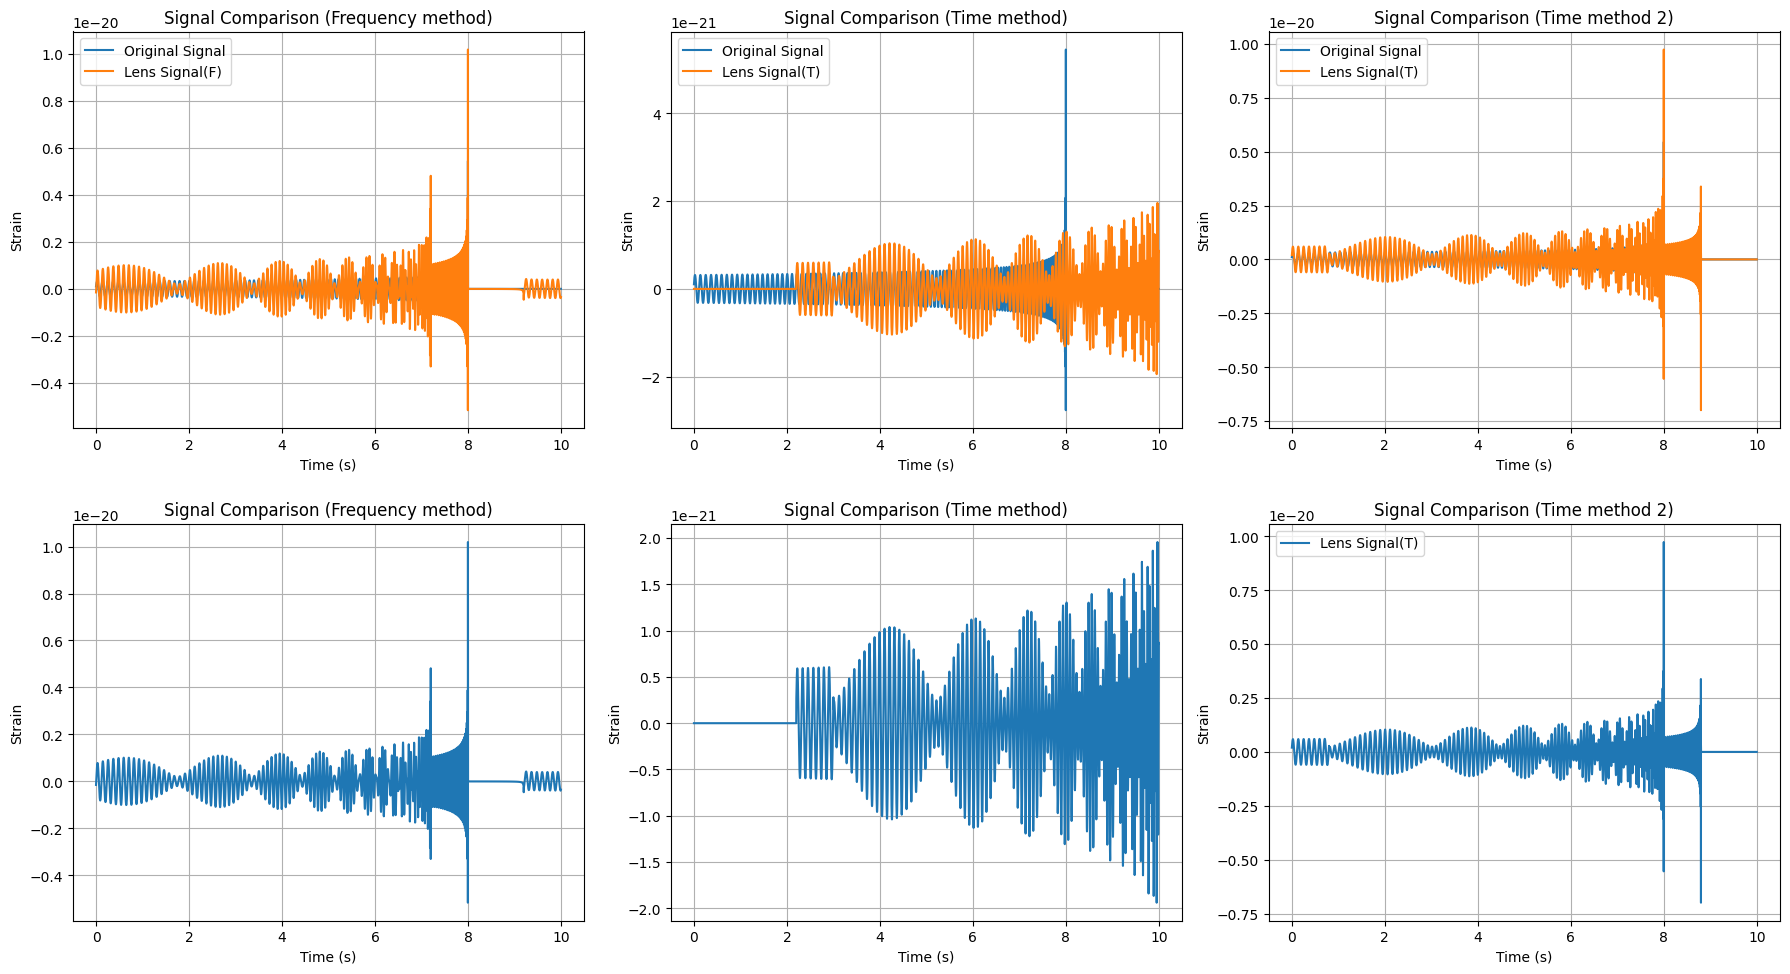

In [202]:
# 初始参数 - GW150914
m1 = 36          # 第一个黑洞质量（太阳质量）
m2 = 29          # 第二个黑洞质量（太阳质量）
M_chirp = (m1 * m2 / (m1 + m2) ** 2) ** (3/5) * (m1 + m2)  # 啁啾质量
M_chirp = M_chirp * msun  # 转换为kg

# 透镜参数
mlz = 1e7 * msun  # 透镜质量
y = 0.4          # 影响参数

# 采样参数 - 与LIGO一致
fs = 16384         # 采样率调整为LIGO的标准采样率
dt = 1/fs
t = np.arange(0, 10, dt)  # 时间范围调整，使其更加聚焦于合并前的最后阶段
t_len = t[-1] - t[0]
N = len(t)
print(f'm1：{m1}')
print(f'm2：{m2}')
print(f'啁啾质量：{M_chirp / msun:.2f}')
print(f'采样率：{fs}')
print(f'总样本数：{N}')
# 引力波参数 - 调整以匹配GW150914
tc = 8      # 合并时间，选择使信号在最后时刻达到峰值
phi_c = 0         # 合并时的相位

# SIS透镜参数
v = 1e6           # 速度弥散，m/s
# GW150914的距离参数（以米为单位）
Ds = 410 * 1e6 * pc   # 源距离 (410 Mpc)
Dl = 205 * 1e6 * pc   # 透镜距离 (205 Mpc)
Dls = Ds - Dl         # 透镜到源的距离 (205 Mpc)

# 函数：引力波波形生成（啁啾信号）
def generate_gw_signal(t):
    # 确保在合并前截止
    valid_idx = t < tc
    t_valid = t[valid_idx]
    # 计算Θ(t)，控制信号的频率演化
    Theta = c**3 * (tc - t_valid) / (5 * G * M_chirp)
    # 计算振幅部分
    A = (G * M_chirp / (c**2 * Ds)) * Theta**(-1/4)
    
    # 原始相位计算
    phase = 2 * phi_c - 2 * Theta**(5/8)
    # phase = 0.4 * phase
    
    # 计算波形
    h = np.zeros_like(t)
    h[valid_idx] = A * np.cos(phase)
    return h

# 函数：透镜放大因子（频域）
def lens_frequency(w, y):
    # 计算放大因子
    mu_plus = np.sqrt(1 + 1/y)
    mu_minus = np.sqrt(-1 + 1/y) if y < 1 else 0
    
    # 确保y小于1，否则无双像
    if y >= 1:
        F_geo = mu_plus
    else:
        # 按照公式计算频域放大因子
        F_geo = mu_plus - 1j * mu_minus * np.exp(1j * w * 2 * y)
    
    return F_geo    

def lens_time(t, y, tc):
    # 初始化卷积核
    kernel = np.zeros_like(t)

    # 计算放大因子
    mu_plus = np.sqrt(1 + 1/y)  # 第一个像（极小点）
    mu_minus = np.sqrt(-1 + 1/y) if y < 1 else 0  # 第二个像（鞍点）

    # 计算物理时间延迟
    td = 2 * y  # 简化形式
    t_2 = tc # 第二个脉冲

    # 第一个脉冲位置（比第二个脉冲更早）
    t_1 = t_2 - td

    # 检查第一个脉冲是否在时间轴范围内
    if t_1 < t[0]:
        # 如果第一个脉冲超出范围，需要压缩时间延迟
        t_1 = t[0]  # 略微偏离起始点

    # 找到最接近的时间点
    idx_pulse1 = np.argmin(np.abs(t - t_1))
    idx_pulse2 = np.argmin(np.abs(t - t_2 ))

    # 设置卷积核中的脉冲值
    kernel[idx_pulse1] = mu_plus
    if y < 1:  # 只有当y<1时才有第二个像
        kernel[idx_pulse2] = -mu_minus

    return kernel, td

# 计算引力波信号
h_original = generate_gw_signal(t)

# 计算频域信号
h_freq = rfft(h_original)
freqs = rfftfreq(N, dt)
w = 2 * np.pi * freqs  # 角频率

# 计算透镜放大因子（频域）
F_lens = np.array([lens_frequency(freq, y) for freq in w])

# 确保长度匹配
min_len = min(len(h_freq), len(F_lens))
h_freq_matched = h_freq[:min_len]
F_lens_matched = F_lens[:min_len]

# 应用透镜效应（频域相乘）
h_lensed_freq = h_freq_matched * F_lens_matched

# 准备频率轴以确保一致性
freqs_matched = freqs[:min_len]

# 转换回时域
h_lensed = np.real(irfft(h_lensed_freq, n=N))

# 通过时域卷积实现透镜效应
kernel, td = lens_time(t, y,tc)
h_lensed_conv = signal.convolve(h_original, kernel, mode= 'same')

# 计算放大因子
mu_plus = np.sqrt(np.abs(1 + 1/y))
mu_minus = np.sqrt(np.abs(-1 + 1/y)) if y < 1 else 0

# 输出计算的时间延迟
print(f"计算的时间延迟: {td} 秒")
print(f"透镜效应中的mu_plus: {mu_plus:.4f}")
print(f"透镜效应中的mu_minus: {mu_minus:.4f}")
def lens_time_domain_advanced(h_original, t, y):
    """高级版本的时域透镜实现，处理了边界条件和非整数延迟"""
    
    # 计算放大因子
    mu_plus = np.sqrt(1 + 1/y)  # 主像
    mu_minus = np.sqrt(-1 + 1/y) if y < 1 else 0  # 次像
    
    # 计算物理时间延迟
    td = 2 * y  # 秒
    
    # 创建延迟信号（使用插值实现亚采样精度）
    from scipy.interpolate import interp1d
    
    # 创建插值函数
    interp_func = interp1d(t, h_original, kind='cubic', bounds_error=False, fill_value=0)
    
    # 创建延迟时间点
    t_delayed = t -td 
    print(t_delayed)
    
    # 计算延迟信号
    h_delayed = interp_func(t_delayed)
    
    # 透镜化效应：原始信号和延迟信号的组合
    h_lensed = mu_plus * h_original
    
    # 只有在y<1时才有次像
    if y < 1:
        h_lensed = h_lensed - mu_minus * h_delayed  # 次像有π相位差(负号)
    
    return h_lensed

h_lens_new = lens_time_domain_advanced(h_original, t, y)

# 绘制原始信号的时域和频域表示
plt.figure(figsize=(18, 12)) 

# 时域原始信号
plt.subplot(221)
plt.plot(t, h_original)
plt.title('Signal (Time Domain)')
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.grid(True)

# 频域原始信号（振幅）
plt.subplot(222)
plt.semilogy(freqs_matched, np.abs(h_freq_matched))
plt.title('Signal (Frequency Domain)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.xlim(0, 500)  # 设置x轴限制以便于查看GW150914的频率范围
plt.grid(True)

# 透镜后信号（时域）
plt.subplot(223)
plt.plot(t, h_original,label = 'signal')
plt.plot(t, h_lensed, label='Frequency Domain Method')
plt.plot(t, h_lensed_conv, 'r--', label='Time Domain Convolution')
plt.plot(t, h_lens_new, label='Time Domain method 2')
plt.title('Lensed Signal (Time Domain)')
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.legend()
plt.grid(True)

# 透镜后信号（频域振幅）
plt.subplot(224)
plt.semilogy(freqs_matched, np.abs(h_freq_matched),label = 'signal')
plt.semilogy(freqs_matched, np.abs(h_lensed_freq),label = 'lens signal')
plt.title('Frequency comparison')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.xlim(0, 500)  # 设置x轴限制
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('lensing_effects.png', dpi=300)
plt.show()

# 透镜效应的比较图（时域）
plt.figure(figsize=(18, 10))
plt.subplot(231)
plt.plot(t, h_original, label='Original Signal')
plt.plot(t, h_lensed, label='Lens Signal(F)')
plt.title('Signal Comparison (Frequency method)')
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.legend()
plt.grid(True)


plt.subplot(232)
plt.plot(t, h_original, label='Original Signal')
plt.plot(t, h_lensed_conv, label='Lens Signal(T)')
plt.title('Signal Comparison (Time method)')
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.legend()
plt.grid(True)

plt.subplot(233)
plt.plot(t, h_original, label='Original Signal')
plt.plot(t, h_lens_new, label='Lens Signal(T)')
plt.title('Signal Comparison (Time method 2)')
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.legend()
plt.grid(True)

plt.subplot(234)
plt.plot(t, h_lensed, label='Lens Signal(F)')
plt.title('Signal Comparison (Frequency method)')
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.grid(True)

plt.subplot(235)
plt.plot(t, h_lensed_conv, label='Lens Signal(T)')
plt.title('Signal Comparison (Time method)')
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.grid(True)
plt.subplot(236)
plt.plot(t, h_lens_new, label='Lens Signal(T)')
plt.title('Signal Comparison (Time method 2)')
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('signal_lens_comparison.png', dpi=300)
plt.show()
